In [25]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Criar Decision Tree

In [26]:
func_dict = {}

In [27]:
def ld_data(dir_name):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in os.listdir(dir_name):
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                lib, func = line.split(' ')
                if '@' in func or '?' in func:
                    continue

                if not func.lower() in func_dict:
                    func_dict[func.lower()] = [(lib, func)]
                else:
                    func_dict[func.lower()].append((lib, func))

                funcs.append(func)

        label = 'MALWARE' if filename.startswith('R') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df


In [28]:
train_dt_dir_name = '../data/arquivos-nilson/'
test_dt_dir_name = '../data/dataset-5557g-8088m/'

In [29]:
train = ld_data(train_dt_dir_name)
test = ld_data(test_dt_dir_name)

test_goodware = test[test['label'] == 'GOODWARE']
test_malware = test[test['label'] == 'MALWARE']

In [30]:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (905, 3)
Test data shape:  (13645, 3)


In [31]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train['funcs']).ceil()
test_g_vectors = vectorizer.transform(test_goodware['funcs']).ceil()
test_m_vectors = vectorizer.transform(test_malware['funcs']).ceil()
test_vectors = vectorizer.transform(test['funcs']).ceil()

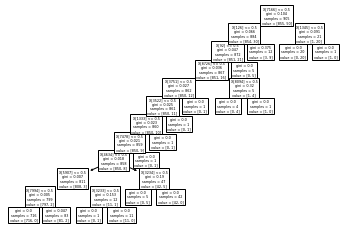

In [32]:
classifier = DecisionTreeClassifier()

classifier.fit(train_vectors, train['label'])

plot_tree(classifier)
plt.savefig('decision_tree.svg')

In [33]:
pred_g = classifier.predict(test_g_vectors)
pred_m = classifier.predict(test_m_vectors)
pred_t = classifier.predict(test_vectors)

In [34]:
# F1 score
print('Accuracy goodwares: {}'.format(accuracy_score(test_goodware['label'], pred_g)))
print('Accuracy malwares: {}'.format(accuracy_score(test_malware['label'], pred_m)))
print('Accuracy total: {}'.format(accuracy_score(test['label'], pred_t)))
print('F1 score: {}'.format(f1_score(test['label'], pred_t, average='weighted')))

Accuracy goodwares: 0.9562713694439445
Accuracy malwares: 0.8444609297725024
Accuracy total: 0.8899963356540858
F1 score: 0.8909168266655114


Text(33.0, 0.5, 'Predicted')

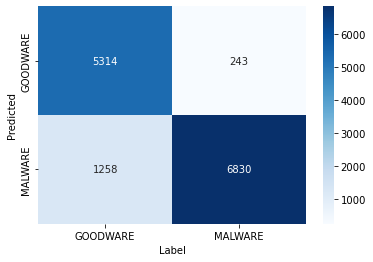

In [35]:
cm = confusion_matrix(test['label'], pred_t)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['GOODWARE', 'MALWARE'], yticklabels=['GOODWARE', 'MALWARE'])
plt.xlabel('Label')
plt.ylabel('Predicted')

In [ ]:
print(vectorizer.get_feature_names_out()[7166])

safercreatelevel


# Criar Yara Rule

In [ ]:
import yara
import yara_tools

In [ ]:
n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold
value = classifier.tree_.value
impurity = classifier.tree_.impurity

In [ ]:
def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] != -1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] != -1):
        right = find_path(children_right[node_numb], path, x)
    if left or right:
        return True
    path.remove(node_numb)
    return False

In [ ]:
def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        if index != len(path) - 1:
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [ ]:
def get_yara_rule(rule, condition_group, path, column_names):
    for index, node in enumerate(path):
        if index != len(path) - 1:
            func_lwr = column_names[feature[node]]
            if (children_left[node] == path[index+1]):
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="and")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'not(pe.imports("{lib}", "{func}"))', condition_group="{}_{}".format(condition_group, index))
            else:
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="or")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'pe.imports("{lib}", "{func}")', condition_group="{}_{}".format(condition_group, index))


In [ ]:
rule = yara_tools.create_rule(name="automatic_rule", default_boolean='or')

rule.add_import(name="pe")

# Leaves
leave_id = classifier.apply(train_vectors)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

# Cut paths that lead to goodwares
filtered_paths = {}
for path in paths:
    n_goodwares, n_malwares = value[path][0]
    if n_malwares > n_goodwares:
        filtered_paths[path] = paths[path]

paths = filtered_paths

for leaf_num in paths:
    rule.create_condition_group(name="group_{}".format(leaf_num), default_boolean='and')
    get_yara_rule(rule, "group_{}".format(leaf_num), paths[leaf_num], vectorizer.get_feature_names_out())

In [ ]:
generated_rule = rule.build_rule(condition_groups=True)

compiled_rule = yara.compile(source=generated_rule)

In [ ]:
print (generated_rule)